# **✦︎ Fine-Tuning SigLIP 2 for Image Classification**

This Colab notebook demonstrates how to fine-tune **[SigLIP 2](https://huggingface.co/google/siglip2-base-patch16-224)** — a powerful multilingual vision-language model — for **single-label image classification** tasks.

Aslo it integrates techniques like captioning-based pretraining, self-distillation, and masked prediction into a unified training pipeline.

---

🤗 **Type 2: Dataset with Only Train Split**

In this setup, the dataset provides only a train split — there is no predefined test or validation set. This is an exceptional case, often encountered in custom or limited datasets.

    Training Phase:
    The model is fine-tuned using the entire train split, with all available image-label pairs.

    Evaluation Phase:
    Since no separate test split is available, a portion of the train split is typically reserved for evaluation (e.g., using a validation split via train_test_split() or K-fold cross-validation).
    Alternatively, the model may be evaluated directly on the training set to get a coarse idea of performance — though this may lead to overfitting.

⚠️ Use this configuration with caution, as evaluating on training data can give an overly optimistic view of performance.

✅ Best suited for exploratory experiments, low-resource scenarios, or datasets collected without test annotations.


**1. Install the packages**

In [1]:
%%capture
!pip install evaluate datasets==3.2.0 accelerate
!pip install transformers==4.50.0 torchvision
!pip install huggingface-hub==0.31.0 hf_xet
#Hold tight, this will take around 2-3 minutes.

**Dataset ID2Label Mapping**

Note : The `id2label` mapping shows how numerical class IDs correspond to human-readable labels.  
This is **not required** for training or evaluation — it's just for **visual reference** and **debugging**.

    To demonstrate the fine-tuning process, we use the (https://huggingface.co/datasets/prithivMLmods/Age-Classification-Set) dataset.

    This dataset contains images labeled by age ranges, making it ideal for training and evaluating SigLIP 2 on an age-based image classification task.


In [2]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("prithivMLmods/Age-Classification-Set")

# Extract unique labels
labels = dataset["train"].features["label"].names

# Create id2label mapping
id2label = {str(i): label for i, label in enumerate(labels)}

# Print the mapping
print(id2label)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md:   0%|          | 0.00/898 [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/502M [00:00<?, ?B/s]

0001.parquet:   0%|          | 0.00/107M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/19016 [00:00<?, ? examples/s]

{'0': '0-12', '1': '13-20', '2': '21-44', '3': '45-64', '4': '65+'}


**2. Import modules required for data manipulation, model training, and image preprocessing.**

In [3]:
import warnings
warnings.filterwarnings("ignore")

import gc
import numpy as np
import pandas as pd
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score
from imblearn.over_sampling import RandomOverSampler
import evaluate
from datasets import Dataset, Image, ClassLabel
from transformers import (
    TrainingArguments,
    Trainer,
    DefaultDataCollator
)

from transformers import AutoImageProcessor
from transformers import SiglipForImageClassification
from transformers.image_utils import load_image

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomRotation,
    RandomResizedCrop,
    RandomHorizontalFlip,
    RandomAdjustSharpness,
    Resize,
    ToTensor
)

from PIL import Image, ExifTags
from PIL import Image as PILImage
from PIL import ImageFile
# Enable loading truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

**3. Loading and Preparing the Dataset**

In [4]:
from datasets import load_dataset
dataset = load_dataset("prithivMLmods/Age-Classification-Set", split="train")

from pathlib import Path

# Build DataFrame from dataset (for oversampling)
file_names = []
labels = []
for example in dataset:
    file_path = str(example['image'])
    label = example['label']
    file_names.append(file_path)
    labels.append(label)

print(len(file_names), len(labels))
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
print("DataFrame shape:", df.shape)
print(df.head())
print("Unique labels:", df['label'].unique())

19016 19016
DataFrame shape: (19016, 2)
                                               image  label
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...      0
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...      0
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...      0
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...      0
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...      0
Unique labels: [0 1 2 3 4]


**4. Creating a DataFrame and Balancing the Dataset & Working with a Subset of Labels**

> Manual Label List (for Custom Naming & Mapping Consistency)

We manually define the `labels_list` to:

    Avoid auto-mapping issues that may arise due to inconsistent label formats in the dataset.

    Support flexible naming conventions, especially when label names need to follow a specific format or order.

    Ensure consistent behavior across different tools (like `ClassLabel`, Hugging Face datasets, and visualization libraries).


In [5]:
df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
print(df.shape)

df.head()
df['label'].unique()

# Oversample to balance classes
y = df[['label']]
df_no_label = df.drop(['label'], axis=1)
ros = RandomOverSampler(random_state=83)
df_resampled, y_resampled = ros.fit_resample(df_no_label, y)
df_resampled['label'] = y_resampled
df = df_resampled  # use the oversampled DataFrame
del y, y_resampled, df_no_label
gc.collect()

#labels_list = ['example_label_0', 'example_label_1'................,'example_label_n-1']
labels_list = ['Child 0-12', 'Teenager 13-20', 'Adult 21-44', 'Middle Age 45-64', 'Aged 65+']

label2id = {label: i for i, label in enumerate(labels_list)}
id2label = {i: label for i, label in enumerate(labels_list)}
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)
print("Mapping of IDs to Labels:", id2label)
print("Mapping of Labels to IDs:", label2id)

(19016, 2)
Mapping of IDs to Labels: {0: 'Child 0-12', 1: 'Teenager 13-20', 2: 'Adult 21-44', 3: 'Middle Age 45-64', 4: 'Aged 65+'}
Mapping of Labels to IDs: {'Child 0-12': 0, 'Teenager 13-20': 1, 'Adult 21-44': 2, 'Middle Age 45-64': 3, 'Aged 65+': 4}


**5. Mapping and Casting Labels**

In [6]:
# Update dataset with label mapping
def map_label2id(example):
    example['label'] = ClassLabels.str2int(example['label'])
    return example

**6. Splitting the Dataset**

In [7]:
dataset = dataset.map(map_label2id, batched=True)
dataset = dataset.cast_column('label', ClassLabels)

full_data = dataset

Map:   0%|          | 0/19016 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/19016 [00:00<?, ? examples/s]

**7. Setting Up the Model and Processor**

In [8]:
model_str = "google/siglip2-base-patch16-224"
processor = AutoImageProcessor.from_pretrained(model_str)

# Extract preprocessing parameters
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


**8. Defining Data Transformations**

In [9]:
# Define training and validation transforms
_train_transforms = Compose([
    Resize((size, size)),
    RandomRotation(90),
    RandomAdjustSharpness(2),
    ToTensor(),
    Normalize(mean=image_mean, std=image_std)
])
_val_transforms = Compose([
    Resize((size, size)),
    ToTensor(),
    Normalize(mean=image_mean, std=image_std)
])

**9. Applying Transformations to the Dataset**

In [10]:
def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

# Create training and evaluation datasets with different transforms
train_data = full_data.with_transform(train_transforms)
eval_data = full_data.with_transform(val_transforms)

**10. Creating a Data Collator**

In [11]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

**11. Initializing the Model**

In [12]:
model = SiglipForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))
model.config.id2label = id2label
model.config.label2id = label2id

print(model.num_parameters(only_trainable=True) / 1e6)

config.json:   0%|          | 0.00/253 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

Some weights of SiglipForImageClassification were not initialized from the model checkpoint at google/siglip2-base-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


92.888069


**12. Defining Metrics and the Compute Function**

In [13]:
accuracy_metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    label_ids = eval_pred.label_ids
    predicted_labels = predictions.argmax(axis=1)
    acc_score = accuracy_metric.compute(predictions=predicted_labels, references=label_ids)['accuracy']
    return {"accuracy": acc_score}

**13. Setting Up Training Arguments**

In [14]:
args = TrainingArguments(
    output_dir="siglip2-image-classification/",
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=2,
    report_to="none"
)

**14. Initializing the Trainer**

In [15]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_data,
    eval_dataset=eval_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

**15. Evaluating, Training, and Predicting**

In [16]:
trainer.evaluate()

trainer.train()

trainer.evaluate()

outputs = trainer.predict(eval_data)
print(outputs.metrics)

{'test_loss': 0.22210857272148132, 'test_model_preparation_time': 0.0026, 'test_accuracy': 0.9179112326461927, 'test_runtime': 301.4337, 'test_samples_per_second': 63.085, 'test_steps_per_second': 7.886}


**16. Computing Additional Metrics and Plotting the Confusion Matrix**

Accuracy: 0.9179
F1 Score: 0.8951


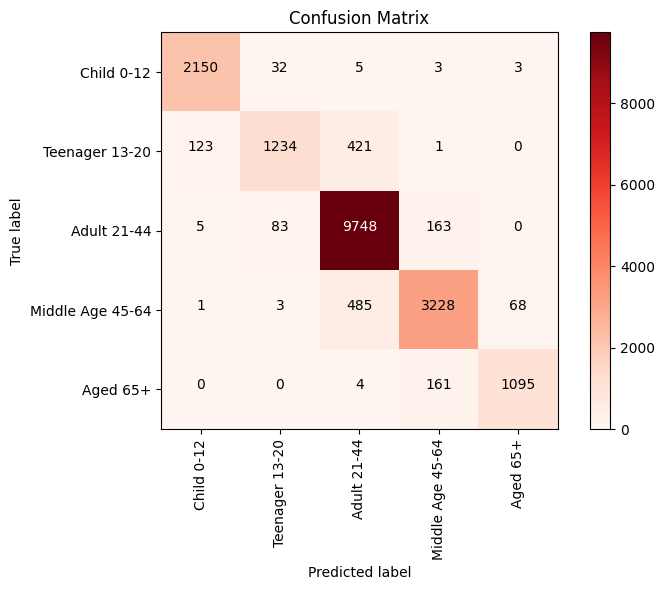


Classification Report:
                  precision    recall  f1-score   support

      Child 0-12     0.9434    0.9804    0.9615      2193
  Teenager 13-20     0.9127    0.6936    0.7882      1779
     Adult 21-44     0.9142    0.9749    0.9436      9999
Middle Age 45-64     0.9078    0.8528    0.8794      3785
        Aged 65+     0.9391    0.8690    0.9027      1260

        accuracy                         0.9179     19016
       macro avg     0.9234    0.8742    0.8951     19016
    weighted avg     0.9178    0.9179    0.9156     19016



In [17]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)


def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Reds, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")

if len(labels_list) <= 150:
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

**17. Saving the Model and Uploading to Hugging Face Hub**

In [18]:
trainer.save_model()

In [19]:
from huggingface_hub import notebook_login, HfApi
notebook_login()

In [20]:
api = HfApi()
repo_id = f"prithivMLmods/Age-Classification-SigLIP2"

api.upload_folder(
    folder_path="siglip2-image-classification/",
    path_in_repo=".",
    repo_id=repo_id,
    repo_type="model",
    revision="main"
)

Uploading...:   0%|          | 0.00/2.49G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/prithivMLmods/Age_Classification_SigLIP2/commit/f270c2f7ae2e87f84095dcc4d726903e3d1ab28c', commit_message='Upload folder using huggingface_hub', commit_description='', oid='f270c2f7ae2e87f84095dcc4d726903e3d1ab28c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/prithivMLmods/Age_Classification_SigLIP2', endpoint='https://huggingface.co', repo_type='model', repo_id='prithivMLmods/Age_Classification_SigLIP2'), pr_revision=None, pr_num=None)

> **Quickstart Demo with Transformers🤗 & Gradio**

You can run a live demo using **Gradio** and your fine-tuned SigLIP 2 model. The demo takes an input image and predicts the **age group** (e.g., Child, Teenager, Adult, etc.) based on the trained model.

In [21]:
%%capture
!pip install gradio

In [22]:
import gradio as gr
from transformers import AutoImageProcessor
from transformers import SiglipForImageClassification
from transformers.image_utils import load_image
from PIL import Image
import torch

# Load model and processor
model_name = "prithivMLmods/Age-Classification-SigLIP2" # Alter your model path
model = SiglipForImageClassification.from_pretrained(model_name)
processor = AutoImageProcessor.from_pretrained(model_name)

def age_classification(image):
    """Predicts the age group of a person from an image."""
    image = Image.fromarray(image).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1).squeeze().tolist()

    #-------------------------------------------------------------------------#
    # Modify the label list to match your model's setup
    labels = {
        "0": "Child 0-12",
        "1": "Teenager 13-20",
        "2": "Adult 21-44",
        "3": "Middle Age 45-64",
        "4": "Aged 65+"
    }
    predictions = {labels[str(i)]: round(probs[i], 3) for i in range(len(probs))}

    return predictions
    #-------------------------------------------------------------------------#

# Create Gradio interface
iface = gr.Interface(
    fn=age_classification,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Label(label="Prediction Scores"),
    title="Age Group Classification",
    description="Upload an image to predict the person's age group."
)

# Launch the app
if __name__ == "__main__":
    iface.launch()

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/372M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://529ec9e6bae2b3961a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


**Demo Inference Screenshots**

The demo inference screenshots are provided below for your reference.  
These examples showcase the model’s predictions on sample inputs after fine-tuning.

> 🧪 Feel free to try your own examples in the Colab notebook!

| ![Screenshot 1](https://cdn-uploads.huggingface.co/production/uploads/65bb837dbfb878f46c77de4c/ccdvZ-blbYtHxHAMSZbtz.png) | ![Screenshot 2](https://cdn-uploads.huggingface.co/production/uploads/65bb837dbfb878f46c77de4c/Yh8GQOM-saLCu_cUTh3Zj.png) |
|:--:|:--:|
| ![Screenshot 3](https://cdn-uploads.huggingface.co/production/uploads/65bb837dbfb878f46c77de4c/9RwNBosF52g--LiaI0eqr.png) | ![Screenshot 4](https://cdn-uploads.huggingface.co/production/uploads/65bb837dbfb878f46c77de4c/VTkOBtHdNposCJnEZVjjx.png) |



This notebook provides a complete pipeline to fine-tune **SigLIP 2** for single-label image classification tasks.  
By leveraging advanced training techniques like **captioning-based pretraining**, **self-distillation**, and **masked prediction**, you can boost performance on a wide range of datasets. Whether you're working with multilingual labels, imbalanced classes, or custom naming schemes, this setup is flexible and ready for experimentation.

    You can find the fine-tuned model here: https://huggingface.co/prithivMLmods/Age-Classification-SigLIP2

Ready to adapt for your own datasets and downstream tasks!

**🎉 Happy Fine-Tuning!**

> **Made with 🤗 x ❤️ by [Prithiv Sakthi](https://www.linkedin.com/in/prithiv-sakthi/)**

Feel free to fork, modify, and explore!